In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Point
import plotly_express as px
import plotly.io as pio
import numpy as np
import folium
from folium.plugins import HeatMap
from folium import branca
from branca.element import Figure

## Visualizations for votes in Rio Grande do Sul in 2022

This page is to aggregate here the visualizations for votes in the RS state

### Data import, slicing and dicing

In [19]:
df = pd.read_csv(r"CSV/votacao_secao_2022_BR.csv", encoding="Latin 1", sep=";")
df_nome_locais = df[['NM_MUNICIPIO', 'NR_ZONA', 'NR_SECAO','NR_LOCAL_VOTACAO','NM_LOCAL_VOTACAO', 'DS_LOCAL_VOTACAO_ENDERECO']].drop_duplicates()
df_nome_locais.to_csv('CSV/NomesLocais.csv')

geocoded_df = pd.read_csv("CSV/geocoded_voting_places_001.csv")
df_lat_long = df.merge(geocoded_df, on = ['CD_MUNICIPIO', 'NR_ZONA', 'NR_LOCAL_VOTACAO'], how = 'left')

#### Subset data for Porto Alegre city only

In [38]:
df_turno2_pres_rs_poa = df_lat_long[
    (df_lat_long['NR_TURNO']==2)&
    (df_lat_long['NM_MUNICIPIO']=='PORTO ALEGRE')&
    (df_lat_long['SG_UF']=='RS')&
    (df_lat_long['DS_CARGO']=='PRESIDENTE')&
    ((df_lat_long['NM_VOTAVEL']=='LUIZ INÁCIO LULA DA SILVA')|(df_lat_long['NM_VOTAVEL']=='JAIR MESSIAS BOLSONARO'))
    ][['NR_ZONA','NM_VOTAVEL','QT_VOTOS','NR_LATITUDE','NR_LONGITUDE','NM_LOCAL_VOTACAO']].groupby(by=
    ['NR_LATITUDE','NR_LONGITUDE','NR_ZONA','NM_VOTAVEL','NM_LOCAL_VOTACAO']).sum('QT_VOTOS')


#### Subset data for RS state only

In [39]:
df_turno2_pres_rs = df_lat_long[
    (df_lat_long['NR_TURNO']==2)&
    (df_lat_long['SG_UF']=='RS')&
    (df_lat_long['DS_CARGO']=='PRESIDENTE')&
    ((df_lat_long['NM_VOTAVEL']=='LUIZ INÁCIO LULA DA SILVA')|(df_lat_long['NM_VOTAVEL']=='JAIR MESSIAS BOLSONARO'))
    ][['NR_ZONA','NM_VOTAVEL','QT_VOTOS','NR_LATITUDE','NR_LONGITUDE','NM_LOCAL_VOTACAO']].groupby(by=
    ['NR_LATITUDE','NR_LONGITUDE','NR_ZONA','NM_VOTAVEL','NM_LOCAL_VOTACAO']).sum('QT_VOTOS')


#### Create pivot table with total vote counts

##### Porto Alegre city votes dataframe

In [40]:
df_turno2_pres_rs_poa_pivot = pd.pivot_table(df_turno2_pres_rs_poa, values = 'QT_VOTOS', index=['NR_LATITUDE','NR_LONGITUDE','NR_ZONA','NM_LOCAL_VOTACAO'], columns = 'NM_VOTAVEL').reset_index()
df_turno2_pres_rs_poa_pivot['difference'] = df_turno2_pres_rs_poa_pivot['LUIZ INÁCIO LULA DA SILVA']-df_turno2_pres_rs_poa_pivot['JAIR MESSIAS BOLSONARO']
df_turno2_pres_rs_poa_pivot['size'] = df_turno2_pres_rs_poa_pivot['difference'].abs()
df_turno2_pres_rs_poa_pivot.dropna(inplace=True)

##### RS state votes dataframe

In [41]:
df_turno2_pres_rs_pivot = pd.pivot_table(df_turno2_pres_rs, values = 'QT_VOTOS', index=['NR_LATITUDE','NR_LONGITUDE','NR_ZONA','NM_LOCAL_VOTACAO'], columns = 'NM_VOTAVEL').reset_index()
df_turno2_pres_rs_pivot['difference'] = df_turno2_pres_rs_pivot['LUIZ INÁCIO LULA DA SILVA']-df_turno2_pres_rs_pivot['JAIR MESSIAS BOLSONARO']
df_turno2_pres_rs_pivot['size'] = df_turno2_pres_rs_pivot['difference'].abs()
df_turno2_pres_rs_pivot.dropna(inplace=True)

### Create visualization 1: votes distributed by neighborhood in Porto Alegre

#### Create geographic dataframe

In [42]:
long = df_turno2_pres_rs_poa_pivot['NR_LONGITUDE']
lat =  df_turno2_pres_rs_poa_pivot['NR_LATITUDE']
geometry = [Point(xy) for xy in zip(long,lat)]
geo_df = gpd.GeoDataFrame(geometry = geometry)
geo_df['size'] = df_turno2_pres_rs_poa_pivot['size']
geo_df['diff'] = df_turno2_pres_rs_poa_pivot['difference']
geo_df['NR_ZONA'] = df_turno2_pres_rs_poa_pivot['NR_ZONA']
geo_df['size_s'] = geo_df['size']/5 

#### Merge voting points and merge spatially with vote points. Visualize the result:

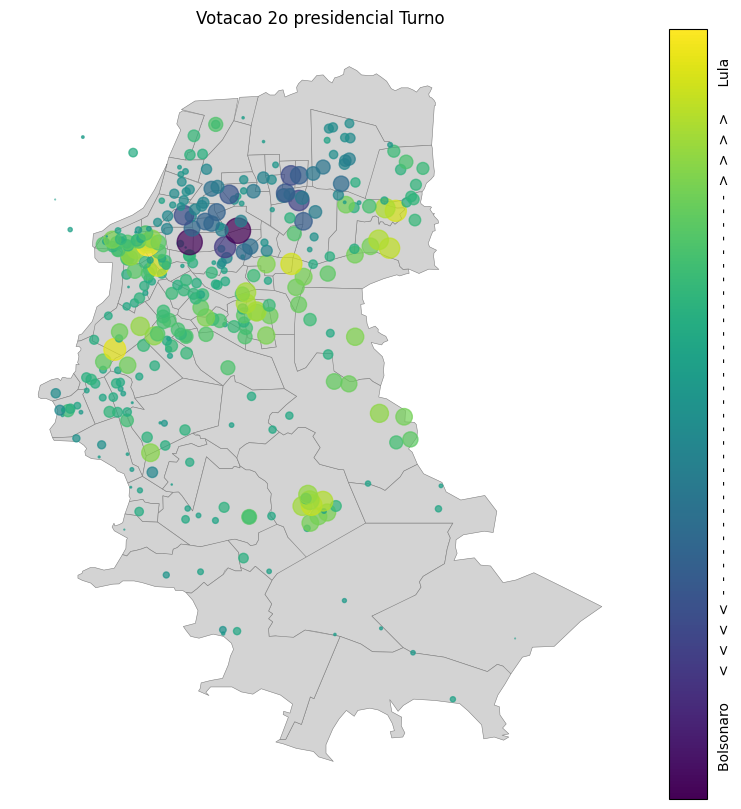

In [43]:
poa_map = gpd.read_file('Shapefiles/Zonas_Poa.shp')

fig, ax = plt.subplots()
axa = poa_map.plot(ax=ax, color='lightgray', edgecolor='grey', linewidth=0.4)
axb = geo_df.plot(ax=ax, c=geo_df['diff'], markersize='size_s', alpha=0.7, categorical=False, legend=True )
mappable = ax.collections[0]
fig.colorbar(mappable=mappable, ticks=[], label='Bolsonaro      <  <  <  <  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  >  >  >  >      Lula')
fig.set_figheight(10)
fig.set_figwidth(10)
plt.title('Votacao 2o presidencial Turno')
plt.axis('off')
plt.show()

### Create visualization 2: votes difference by place

#### Created filtered dataframe

In [46]:
df_turno2_pres_rs_pivot['total_v'] = df_turno2_pres_rs_pivot['JAIR MESSIAS BOLSONARO'] + df_turno2_pres_rs_pivot['LUIZ INÁCIO LULA DA SILVA'] 

In [47]:
df_turno2_pres_rs_pivot

NM_VOTAVEL,NR_LATITUDE,NR_LONGITUDE,NR_ZONA,NM_LOCAL_VOTACAO,JAIR MESSIAS BOLSONARO,LUIZ INÁCIO LULA DA SILVA,difference,size,total_v
0,-33.734513,-53.369660,43,ESC. MUN. ENS. FUND.JOSE BERNARDINO DE SOUZA C...,78.0,179.0,101.0,101.0,257.0
1,-33.689258,-53.471604,43,ESC. MUN. ENS. FUND. GENERAL ARTIGAS,374.0,821.0,447.0,447.0,1195.0
2,-33.688137,-53.452857,43,ESC. ENS. MED. MARECHAL SOARES DE ANDREA,694.0,1152.0,458.0,458.0,1846.0
3,-33.663962,-53.263807,43,ESC. MUN. ENS. FUND. COL. ALVARO AUGUSTO DE CA...,180.0,292.0,112.0,112.0,472.0
4,-33.535154,-53.372193,43,GRUPO ESCOLAR WANDELINA NUNES,264.0,683.0,419.0,419.0,947.0
...,...,...,...,...,...,...,...,...,...
7966,-27.115086,-53.389483,94,SALAO COMUNITARIO,112.0,118.0,6.0,6.0,230.0
7967,-24.975431,-49.084499,154,ESCOLA MUNICIPAL CASEMIRO DE ABREU,79.0,211.0,132.0,132.0,290.0
7968,-24.975431,-49.084499,154,ESCOLA MUNICIPAL RUI RAMOS,74.0,96.0,22.0,22.0,170.0
7969,-24.975431,-49.084499,154,ESCOLA MUNICIPAL SAO SEBASTIAO,53.0,145.0,92.0,92.0,198.0


#### Show visualization

In [48]:
lat_foc = -30
lon_foc = -51
fig = px.scatter_mapbox(df_turno2_pres_rs_pivot,lat="NR_LATITUDE",
    lon="NR_LONGITUDE",size='total_v',color='difference', custom_data=['NR_ZONA', 'NM_LOCAL_VOTACAO', 'difference', 'total_v']).update_layout(mapbox={"style": "carto-positron", "zoom": 4}, margin={"t":0,"b":0,"l":0,"r":0})
fig.update_traces(
    hovertemplate="<br>".join([
        "Zona: %{customdata[0]}",
        "Local: %{customdata[1]}",
        "Diferenca: %{customdata[2]}",
        "Total Votos: %{customdata[3]}"
    ])
)

#pio.write_html(fig, file='HTML files/Votos_RS_2oTurno.html', auto_open=True)
fig.show()

### Create visualization 3: votes difference heatmap with Folium

#### Deduplicate the dataset

In [28]:
df_turno2_pres_rs_poa_pivot.drop_duplicates(subset='NR_LATITUDE', keep="last", inplace=True)

#### Create 2 dataframes for each candidate with respective advantages

In [29]:
df_map_lula = df_turno2_pres_rs_poa_pivot[df_turno2_pres_rs_poa_pivot['difference']>0][['NR_LATITUDE','NR_LONGITUDE','size']]
df_map_jair = df_turno2_pres_rs_poa_pivot[df_turno2_pres_rs_poa_pivot['difference']<0][['NR_LATITUDE','NR_LONGITUDE','size']]

#### Show visualization with Folium

In [51]:
df_map_lula.columns = ['lat','lon','val']
df_map_jair.columns = ['lat','lon','val']

fig = Figure(width=800, height=600)
m = folium.Map(location = [-30.1, -51.2], tiles="OpenStreetMap", zoom_start=9, width=800, height=600)
lgd_txt = '<span style="color: {col};">{txt}</span>'

HeatMap(data=df_map_lula.values, min_opacity=0.1, gradient={.01: 'purple', .15: 'yellow', 1: 'orange'}, name=lgd_txt.format( txt= 'Vantagem em votos pró Lula', col= 'orange')).add_to(m)
HeatMap(data=df_map_jair.values, min_opacity=0.1, gradient={.01: 'purple', .15: 'lime', 1: 'green'}, name=lgd_txt.format( txt= 'Vantagem em votos pró Bolsonaro', col= 'green')).add_to(m)
# fg = folium.FeatureGroup(name= lgd_txt.format( txt= 'Empate', col= 'purple'))
# m.add_child( fg)
folium.map.LayerControl('topright', collapsed= False).add_to(m)


m.save('HTML files/Heatmap_RS_2oTurno.html')
fig.add_child(m)
